
# prj 나를 찾아줘 - Class Activation Map 만들기





In [1]:
!conda info


     active environment : aiffel
    active env location : /home/ubuntu/anaconda3/envs/aiffel
            shell level : 1
       user config file : /home/ubuntu/.condarc
 populated config files : /home/ubuntu/.condarc
          conda version : 4.5.12
    conda-build version : 3.10.5
         python version : 3.6.10.final.0
       base environment : /home/ubuntu/anaconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/free/linux-64
                          https://repo.anaconda.com/pkgs/free/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/pro/linux-64
                          https://repo.anaconda.com/pkgs/pro/noarch
          package cache : /home/ubuntu/anaconda3/pkgs
       

# library import

In [8]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

# gpu check

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# data set load

- cars196 dataset
- https://www.tensorflow.org/datasets/catalog/cars196

In [10]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

# data check

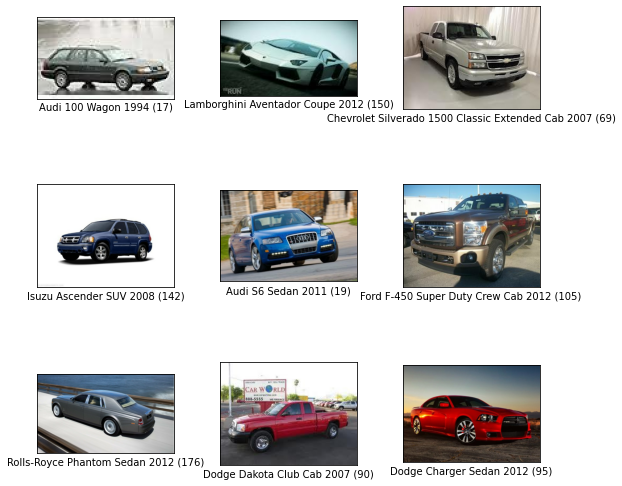

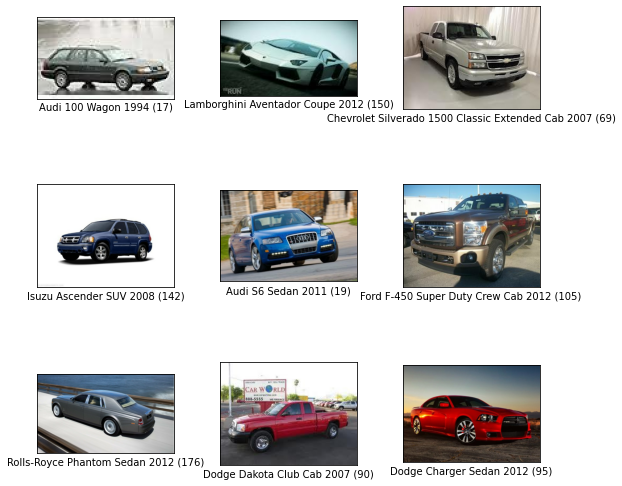

In [11]:
# 이미지 클래스와 인덱스 확인
tfds.show_examples(ds_train, ds_info)

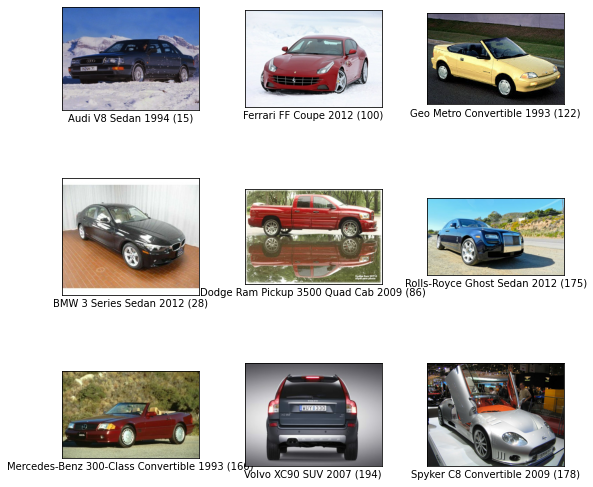

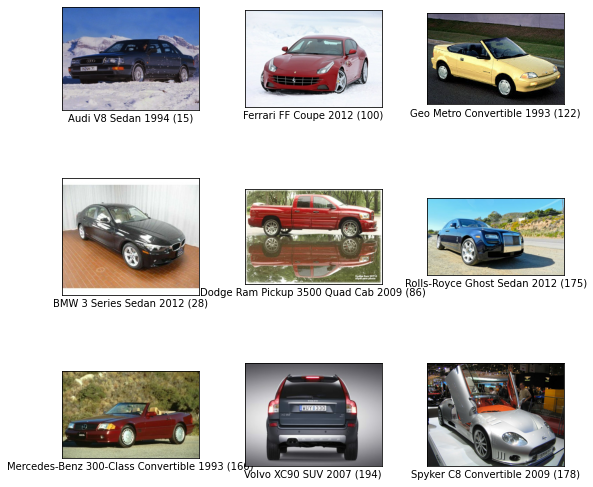

In [12]:
# 평가용 데이터셋 확인
tfds.show_examples(ds_test, ds_info)

In [13]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

## BBoxFeature
- https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GC-3-P-2.jpg)

- 바운딩 박스
- 표기법
    + xywh : (x_center, y_center, width, height), 또는 좌측상단 xy
    + minmax : (x_min, x_max, y_min, y_max)
    + 등등등...


# model

- pretrained model resnet50(imagnet) 기반
     + cam layer add
     + grad-cam layer

In [15]:
num_classes = ds_info.features["label"].num_classes

base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg', # gap 연산
)

x = base_model.output

#preds = ADD_YOUR_LAYER(x)

# global average pooling, softmax

preds =  keras.layers.Dense(num_classes, activation = 'softmax')(x)


cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [16]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [19]:


def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224]) # 이미지 리사이즈 imagnet으로 훈련한 프리트레인(res50)
    input['image'] = tf.cast(image, tf.float32) / 255. # rgb data normalize
    return input['image'], input['label']
    # bbox data 사용안함...


    
    #
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [21]:
# 컴파일

In [22]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [23]:
# train
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 56s 110ms/step - loss: 4.1592 - accuracy: 0.1615 - val_loss: 5.4555 - val_accuracy: 0.0070
Epoch 2/15
509/509 [==============================] - 52s 103ms/step - loss: 1.6815 - accuracy: 0.6302 - val_loss: 1.8732 - val_accuracy: 0.5138
Epoch 3/15
509/509 [==============================] - 52s 103ms/step - loss: 0.5860 - accuracy: 0.8927 - val_loss: 1.2798 - val_accuracy: 0.6711
Epoch 4/15
509/509 [==============================] - 52s 103ms/step - loss: 0.1577 - accuracy: 0.9851 - val_loss: 1.0715 - val_accuracy: 0.7169
Epoch 5/15
509/509 [==============================] - 53s 104ms/step - loss: 0.0501 - accuracy: 0.9975 - val_loss: 1.0253 - val_accuracy: 0.7266
Epoch 6/15
509/509 [==============================] - 52s 103ms/step - loss: 0.0418 - accuracy: 0.9984 - val_loss: 1.0143 - val_accuracy: 0.7315
Epoch 7/15
509/509 [==============================] - 52s 103ms/step - loss: 0.0198 - accuracy: 0.9994 - val_loss: 1.0188 - val_ac

In [ ]:
# model save

In [25]:
import os

cam_model_path = os.getenv('HOME')+'/lsg/data/cam_model.h5'
cam_model.save(cam_model_path)

#  cam 


In [33]:
# 한장에 대한 데이터 출력 함수 선언.
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

141


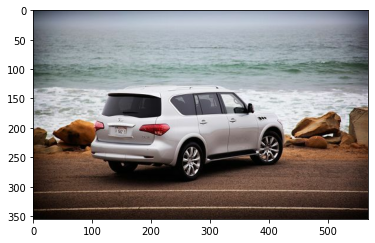

In [34]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [35]:
# model import
cam_model = tf.keras.models.load_model(cam_model_path)

(1) 특성 맵   
(2) 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고    
(3) 원하는 클래스의 출력값    

- CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화 해야 할 것입니다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다

In [60]:
print(cam_model.inputs)
print(cam_model.layers[-3].output) # gap 직전에 output, 
print(cam_model.output)

[<tf.Tensor 'input_2_2:0' shape=(None, 224, 224, 3) dtype=float32>]
Tensor("conv5_block3_out/Relu_3:0", shape=(None, 7, 7, 2048), dtype=float32)
Tensor("dense/Softmax_2:0", shape=(None, 196), dtype=float32)


In [76]:
# conv_outputs< 과 같은 결과 값 정의
# feedforward 이후 캠 계산
# TODO 이해하기

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)

    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    #cam_model.summary()
    
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2]) # 껍대기 만드는듯.
    
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

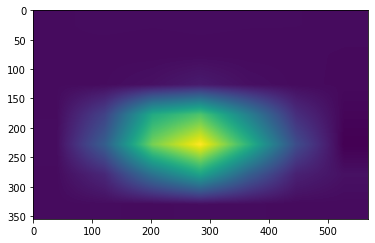

In [50]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [42]:
#원본ㅇ이미지와 합쳐보는 함수
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

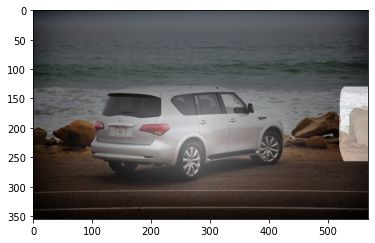

In [62]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# grad -cam

100


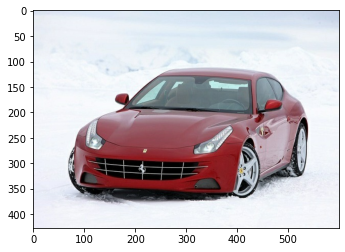

In [63]:
# 이미지 한장 픽
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

- grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합 해주어 cam_image를 얻게 됩니다.

- 위에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다.

- 아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.

In [64]:


def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

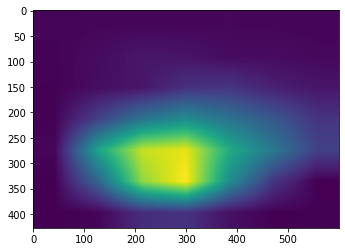

In [68]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

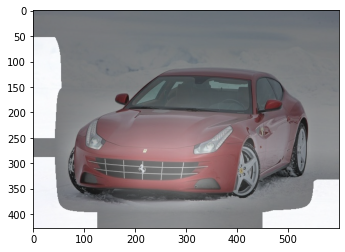

In [69]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

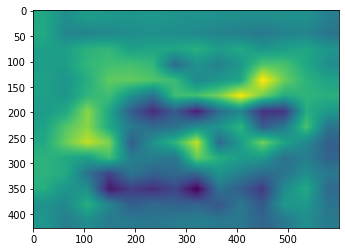

In [70]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

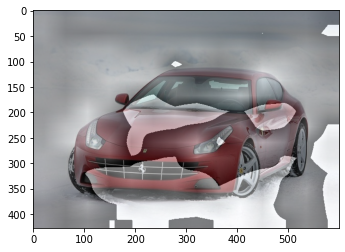

In [71]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

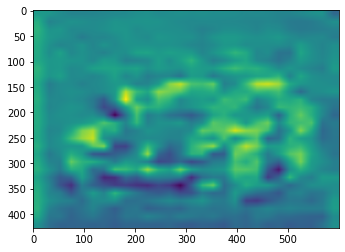

In [72]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

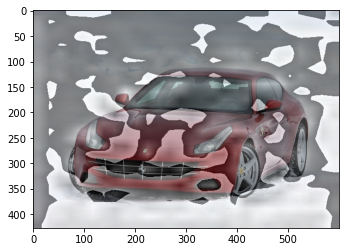

In [73]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# detection with cam

58


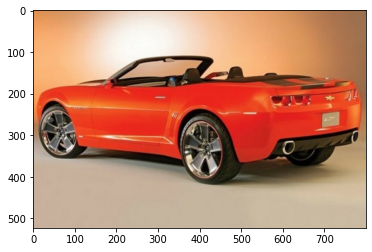

In [78]:
# 이미지 하나 픽
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

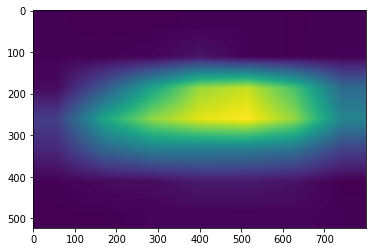

In [79]:
# cam 만들기
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [121]:
# bouding box

def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh #0,1 
    a = cam_image[low_indicies] = 0 # 왜하는 걸까?
    print("low_indicies",low_indicies)
    print("low_indicies", type(low_indicies))
    print(" cam_image[low_indicies] = 0",  a)
    cam_image = (cam_image*255).astype(np.uint8) # norm 했던거 되돌리는듯.
    
    # Contours란 동일한 색 또는 동일한 강도를 가지고 있는 영역의 경계선을 연결한 선
    # OpenCV에서는 contours를 찾는 것은 검은색 배경에서 하얀색 대상을 찾는 것과 비슷합니다.
    #그래서 대상은 흰색, 배경은 검은색으로 해야 합니다. 
    # 그래서 위에서 0,1로 바꾼듯.
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(type(contours)) 
    cnt = contours[0] # 요놈이 경계선 좌표 배열 인듯.
    
    #minAreaRect : contour< 에 외접하여 면적이 가장 작은 직사각혁을 구해주는 함수.
    # 리턴 값은 좌상단 좌표 x,y, 가로 세로 폭과 사각형이 기울어진 각도
    rotated_rect = cv2.minAreaRect(cnt)
    print("rotated_rect", rotated_rect)
    
    #boxPoints 직사각형의 꼭지점 4개의 좌표를 얻을 수 있는 함수. float 값으로 리턴되기에 정수형 변환 필요
    rect = cv2.boxPoints(rotated_rect)
    print("rect",rect)
    
    # 정수형으로 변환
    rect = np.int0(rect)
    return rect

In [122]:
cam_image[cam_image <= 0.05 ]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [123]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

low_indicies [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
low_indicies <class 'numpy.ndarray'>
 cam_image[low_indicies] = 0 0
<class 'list'>
rotated_rect ((399.5, 270.5), (321.0, 799.0), -90.0)
rect [[ 7.990000e+02  4.310000e+02]
 [-9.827791e-15  4.310000e+02]
 [ 0.000000e+00  1.100000e+02]
 [ 7.990000e+02  1.100000e+02]]


array([[799, 431],
       [  0, 431],
       [  0, 110],
       [799, 110]])

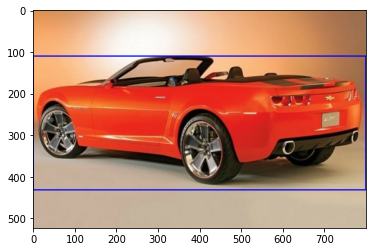

In [124]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

# Intersection Over Union
- cam , grad-cam
- iou

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-3-P-3.max-800x600.jpg)

In [125]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [126]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.21032504780114722, 0.0, 0.8240917782026769, 0.99875]

In [127]:
#gorund true
item['bbox']

array([0.19694072, 0.00625   , 0.8126195 , 0.99125   ], dtype=float32)

In [128]:
# iout 계산 함수 선언
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [129]:
get_iou(pred_bbox, item['bbox'])

0.9474226056620046